In [2]:
import os
import kagglehub
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split

path = kagglehub.dataset_download("phucthaiv02/butterfly-image-classification")
print("Dataset Path:", path)

train_dir = os.path.join(path, "train")
csv_path = os.path.join(path, "Training_set.csv")
organized_train_dir = os.path.join(path, "organized_train")
organized_val_dir = os.path.join(path, "organized_val")
os.makedirs(organized_train_dir, exist_ok=True)
os.makedirs(organized_val_dir, exist_ok=True)

df = pd.read_csv(csv_path)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

def organize_images(df, source_dir, target_dir):
    for _, row in df.iterrows():
        filename = row['filename']
        label = row['label']
        source_path = os.path.join(source_dir, filename)
        target_label_dir = os.path.join(target_dir, str(label))
        os.makedirs(target_label_dir, exist_ok=True)
        if os.path.exists(source_path):
            shutil.copy(source_path, os.path.join(target_label_dir, filename))
        else:
            print(f"File not found: {filename}")

organize_images(train_df, train_dir, organized_train_dir)
organize_images(val_df, train_dir, organized_val_dir)


100%|██████████| 226M/226M [00:02<00:00, 117MB/s]

Extracting files...


Dataset Path: /root/.cache/kagglehub/datasets/phucthaiv02/butterfly-image-classification/versions/2


In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)


train_generator = train_datagen.flow_from_directory(
    organized_train_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=True
)
val_generator = val_datagen.flow_from_directory(
    organized_val_dir, target_size=img_size, batch_size=batch_size, class_mode='categorical', shuffle=False
)

num_classes = len(train_generator.class_indices)
print(f"Number of Classes: {num_classes}")


Found 5199 images belonging to 75 classes.
Found 1300 images belonging to 75 classes.
Number of Classes: 75


In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=img_size + (3,))
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(num_classes, activation="softmax")(x)
baseline_model = Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

baseline_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

baseline_history = baseline_model.fit(
    train_generator, validation_data=val_generator, epochs=5, verbose=1
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 405ms/step - accuracy: 0.2613 - loss: 3.2884 - val_accuracy: 0.7146 - val_loss: 1.3670
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 362ms/step - accuracy: 0.7698 - loss: 1.0738 - val_accuracy: 0.8062 - val_loss: 0.9273
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 369ms/step - accuracy: 0.8403 - loss: 0.7225 - val_accuracy: 0.8285 - val_loss: 0.7596
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 363ms/step - accuracy: 0.8689 - loss: 0.5496 - val_accuracy: 0.8392 - val_loss: 0.6882
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 361ms/step - accuracy: 0.8943 - loss: 0.4604 - val_accuracy: 0.8446 - val_loss: 0.6321


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


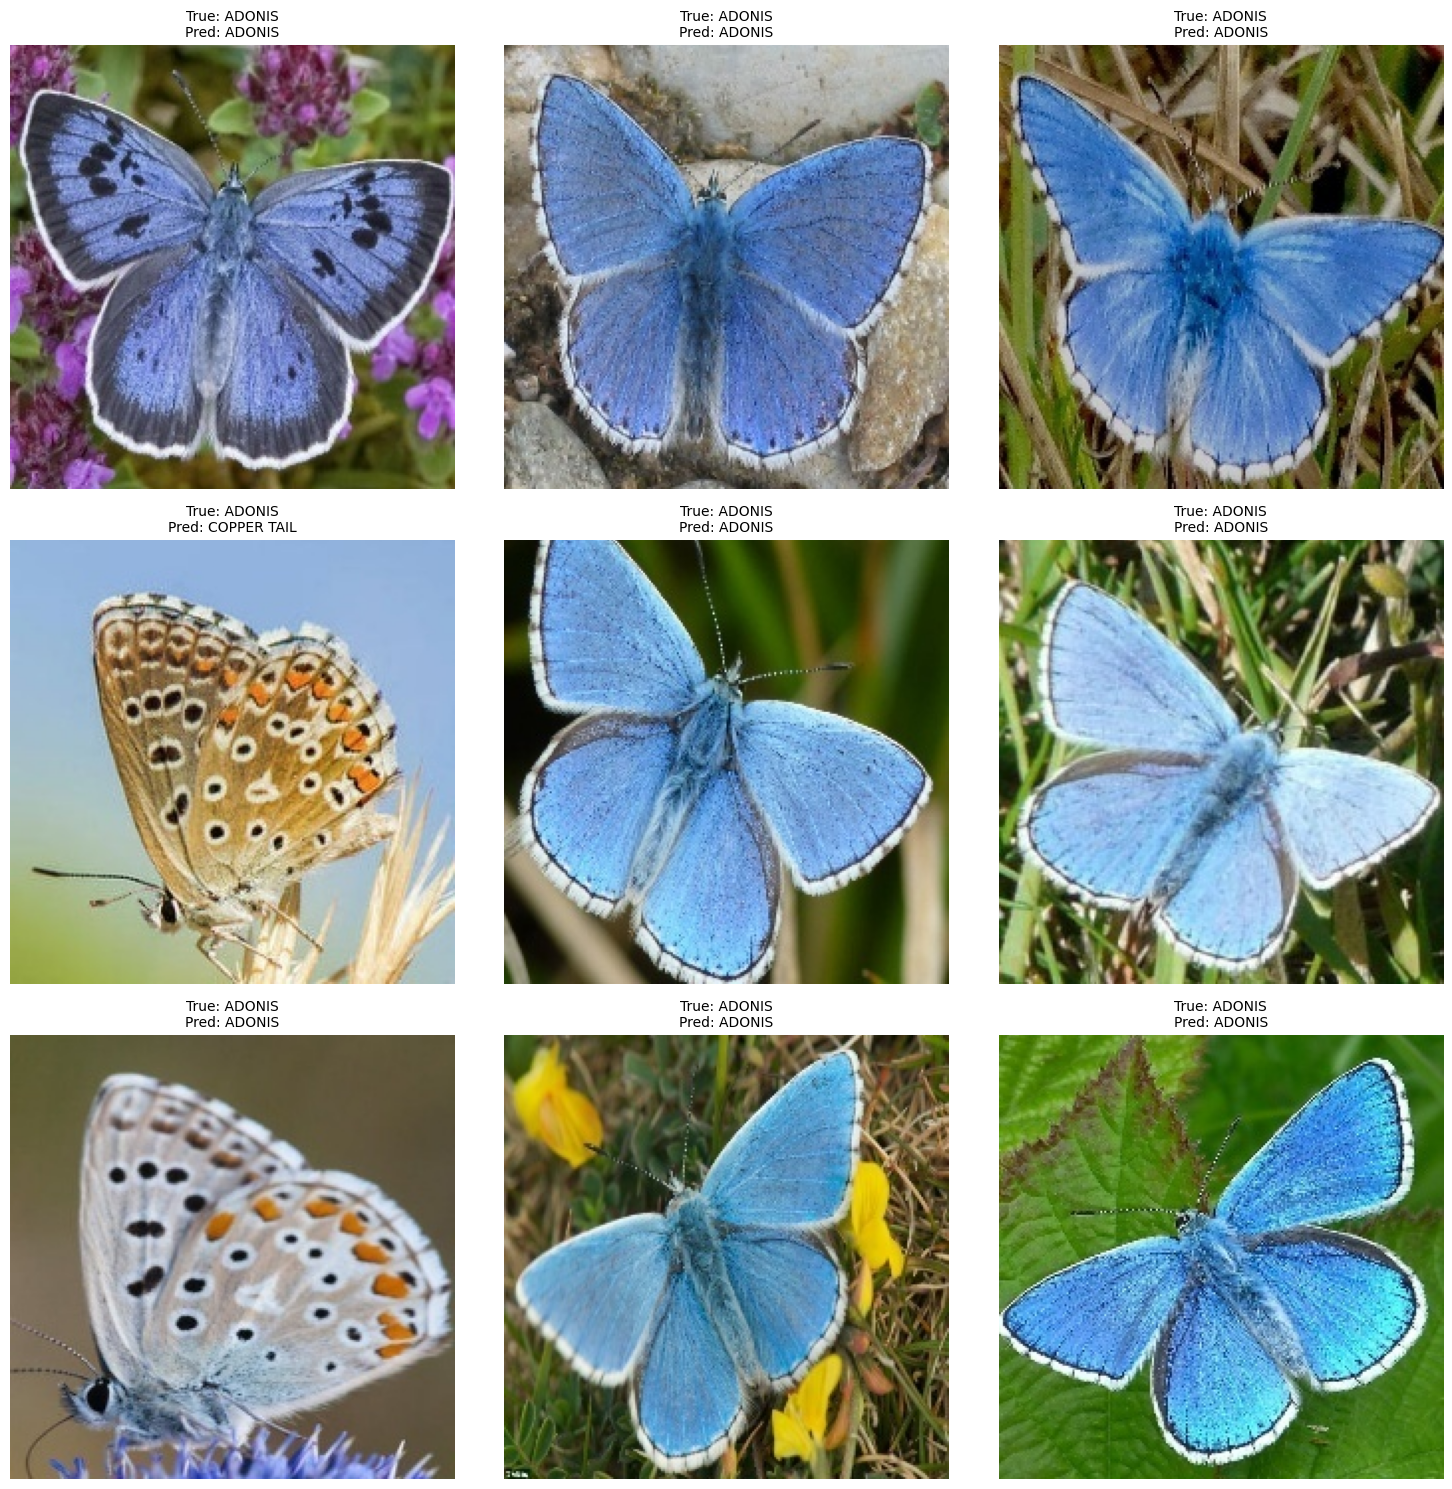

In [30]:
import numpy as np
import matplotlib.pyplot as plt

val_images, val_labels = next(val_generator)
pred_labels = baseline_model.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)


In [35]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import GlobalAveragePooling2D

model = tf.keras.models.Sequential([
    base_model, 
    layers.BatchNormalization(),
    GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.45, seed=123),
    layers.Dense(num_classes, activation='softmax')
])

base_model.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

enhanced_history = model.fit(
    train_generator, validation_data=val_generator, epochs=5, verbose=1
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 7, 7, 1280)          │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_16          │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 75)                  │          19,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,610,315 (9.96 MB)

 Trainable params: 349,771 (1.33 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 421ms/step - accuracy: 0.2431 - loss: 3.3239 - val_accuracy: 0.7538 - val_loss: 1.0602
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - accuracy: 0.6985 - loss: 1.1382 - val_accuracy: 0.8192 - val_loss: 0.6791
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 362ms/step - accuracy: 0.7476 - loss: 0.8565 - val_accuracy: 0.8538 - val_loss: 0.5564
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 367ms/step - accuracy: 0.8015 - loss: 0.6949 - val_accuracy: 0.8500 - val_loss: 0.5112
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 62s 370ms/step - accuracy: 0.8199 - loss: 0.5810 - val_accuracy: 0.8708 - val_loss: 0.4836


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


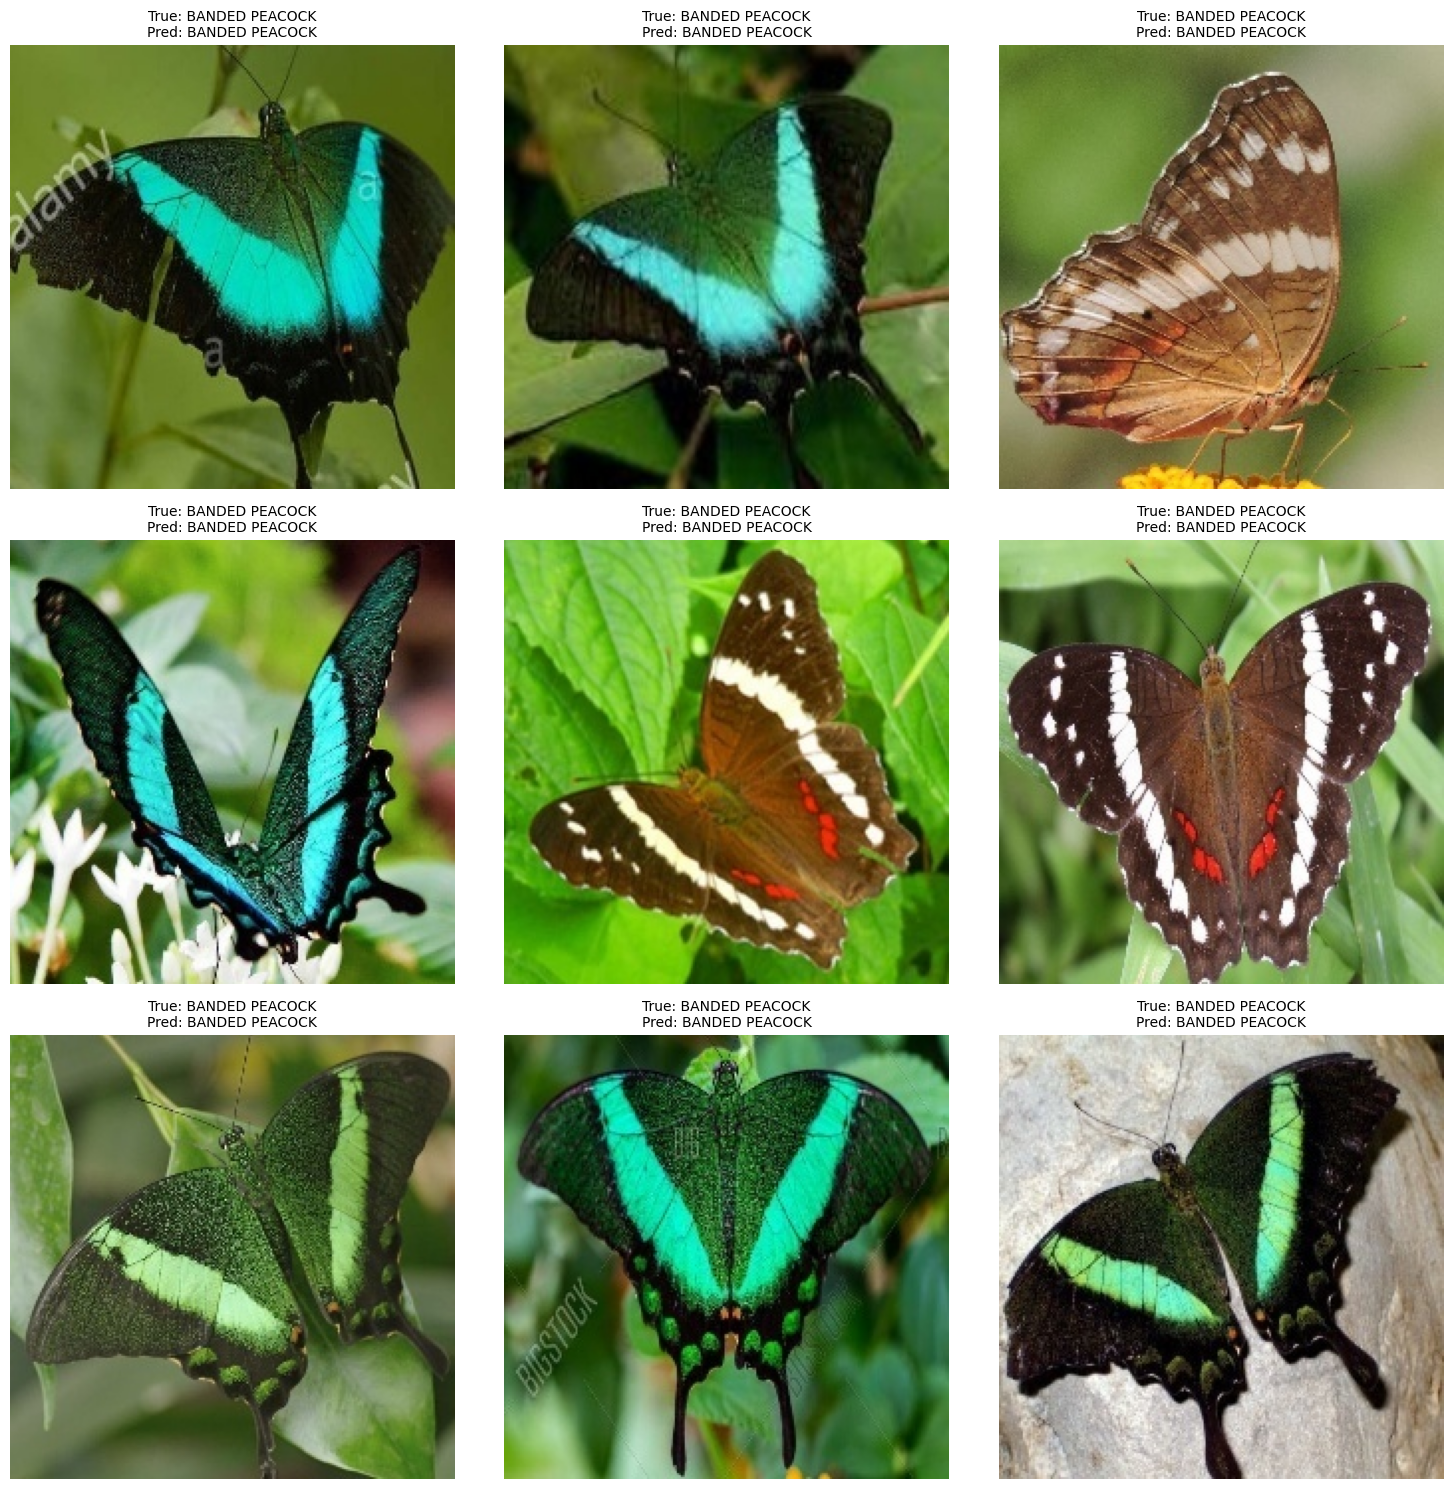

In [38]:
import numpy as np
import matplotlib.pyplot as plt

val_images, val_labels = next(val_generator)
pred_labels = model.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = val_generator.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)


In [39]:
model.save('my_model.h5')